<a href="https://colab.research.google.com/github/Shihori/AI/blob/main/molNW_sec6_cnn_230529_12_11_23_ipynb_TME_12_21_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

編集部注：2023年5月29日最終更新．コードの一部がお手元の書籍と異なる可能性がございます．正誤・更新情報は弊社ウェブサイトの[本書詳細ページ](https://www.yodosha.co.jp/jikkenigaku/book/9784758122634/index.html)をご参照ください．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/molNW/
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/molNW
cell_images/  model.pt  molNW_sec6_cnn_230529_12_11_23_ipynb_のコピー.ipynb


In [ ]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=19310c6d6e1642009fcfb769f8673c0c5835610a701afdba387e911a2c33c325
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
import scipy
import random
from tqdm import tqdm
import glob

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms as transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [ ]:
path = "/content/drive/MyDrive/molNW" #フォルダパス
im_fd = "/cell_images/" #上のパスからImageのあるフォルダの参照

/content/drive/MyDrive/molNW/cell_images/inactivated/3-25-22-TMP-DR1.jpg


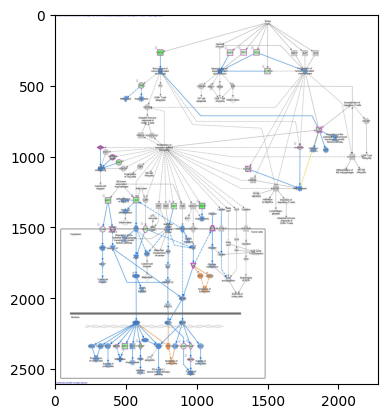

In [ ]:
folder = ['inactivated','activated']
file0 = glob.glob(path + im_fd + folder[0] +"/*.jpg")[0]
print(file0)
image = Image.open(file0) # 画像ファイルの読み込み
plt.imshow(image) #表示

In [ ]:
np.array(image) #画像データを配列として表示

array([[[255, 247, 251],
        [255, 247, 247],
        [255, 251, 248],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 252, 255],
        [255, 252, 253],
        [255, 248, 244],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[249, 247, 248],
        [255, 255, 253],
        [255, 254, 248],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 253, 255],
        [251, 250, 245],
        [255, 255, 230],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 252, 253],
        [255, 255, 246],
        [248, 247, 227],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 250, 241],
        [255, 253, 246],
        [251, 242, 245],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.
print(f"Using {device} device")

Using cuda device


In [ ]:
image_size = 128; #Imageサイズの指定

In [ ]:
SEED = 42

def seed_fix(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_fix(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [ ]:
folder = ['inactivated','activated']
X = [];
y = [];
usenumber = 50
for i,folname in enumerate(folder):
    files1 = glob.glob(path + im_fd + folname +"/*.jpg"); #フォルダ内のファイル名を取得
    f_number = len(files1) #randomに一部のデータのみ抽出するためのコード
    files1, files2=torch.utils.data.random_split(files1,[usenumber,f_number - usenumber])
    for j, file in enumerate(tqdm(files1)):
        outcome = i
        image = Image.open(file) # 画像ファイルの読み込み
        image = image.convert("RGB") # RGBモードに変換
        image = image.resize((image_size, image_size)) # リサイズ
        data = np.asarray(image) # 画像を配列に変換
        X.append(data); # 複数枚を１つの配列に保存
        y.append(outcome)  #正解ラベルをyとして保存

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


In [ ]:
#配列データへの変換 ４次元のデータとして(画像枚数，RGBの層，画像の高さ，画像の横幅)になるように次元を入れ替え
X = np.array(X).astype(np.float32).transpose(0,3,1,2)/255
y = np.array(y)

In [ ]:
Nall = X.shape[0]

In [ ]:
tensor_X = torch.tensor(X, dtype=torch.float32) #Tensor型として変換
tensor_y = torch.tensor(y, dtype=torch.int64) #Tensor型として変換

In [ ]:
dataset = torch.utils.data.TensorDataset(tensor_X,tensor_y)# 目的変数と入力変数をまとめてdatasetに変換
n_train = int(Nall * 0.7) # Training データ数
n_val = int(Nall * 0.2)   # Validation データ数
n_test = Nall - n_train - n_val # Test データ数
train_x, val_x, test_x = torch.utils.data.random_split(dataset, [n_train, n_val,n_test]) # データセットの分割
print("train =",n_train,",validation =",n_val,",Test =",n_test)

train = 70 ,validation = 20 ,Test = 10


In [ ]:
batch_size = 64 #バッチサイズの指定
train_dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)  # data loaderとして指定
val_dataloader   = DataLoader(val_x,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_x,  batch_size=1, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3,128,128),output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=[-7.5, 7.5])
    ]
) #Data augumentation

In [ ]:
#最適化
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.005)

def train(train_loader): #Training
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #data augumentation
        #images = transform(images)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def valid(test_loader): #Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

#空の配列
acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
nepoch = 300

#Fitting
for epoch in range(nepoch):
    loss, acc = train(train_dataloader)
    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6946 acc: 0.4571 val_loss: 0.6946 val_acc: 0.4500
epoch 1, loss: 0.6935 acc: 0.4857 val_loss: 0.6945 val_acc: 0.4500
epoch 2, loss: 0.6927 acc: 0.5429 val_loss: 0.6943 val_acc: 0.4500
epoch 3, loss: 0.6901 acc: 0.4857 val_loss: 0.6941 val_acc: 0.4500
epoch 4, loss: 0.6941 acc: 0.4000 val_loss: 0.6938 val_acc: 0.4500
epoch 5, loss: 0.6914 acc: 0.5000 val_loss: 0.6933 val_acc: 0.4500
epoch 6, loss: 0.6922 acc: 0.5714 val_loss: 0.6928 val_acc: 0.5500
epoch 7, loss: 0.6909 acc: 0.5143 val_loss: 0.6922 val_acc: 0.5500
epoch 8, loss: 0.6924 acc: 0.5143 val_loss: 0.6916 val_acc: 0.5500
epoch 9, loss: 0.6948 acc: 0.5286 val_loss: 0.6912 val_acc: 0.5500
epoch 10, loss: 0.6943 acc: 0.5143 val_loss: 0.6909 val_acc: 0.5500
epoch 11, loss: 0.6878 acc: 0.5143 val_loss: 0.6907 val_acc: 0.5500
epoch 12, loss: 0.6999 acc: 0.5143 val_loss: 0.6905 val_acc: 0.5500
epoch 13, loss: 0.6930 acc: 0.5143 val_loss: 0.6906 val_acc: 0.5500
epoch 14, loss: 0.6892 acc: 0.5143 val_loss: 0.6906 val_ac

In [ ]:
#modelの保存
torch.save(model, 'model.pt')

In [ ]:
#読み込み
model = torch.load('model.pt')

正解率： 55.00000000000001 %


Text(0, 0.5, 'acc')

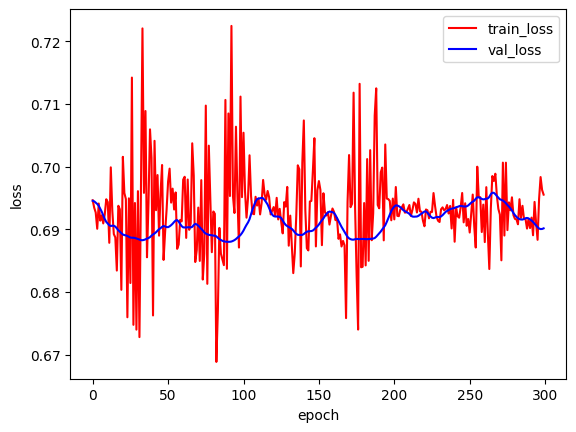

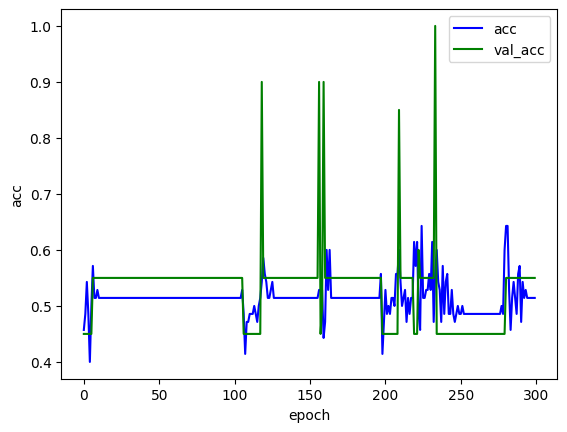

In [ ]:
print('正解率：',val_acc_list[-1]*100, '%')

#学習過程の表示
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

モデル評価：テストデータへの当てはめ

In [ ]:
#For Test
def test(test_loader):
    prob = []
    pred = []
    true = []
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            lprob, predicted = outputs.max(1, keepdim=True)
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            prob = np.append(prob, scipy.special.expit(torch.Tensor.numpy(outputs[:,1].to('cpu'))))
            pred = np.append(pred, torch.Tensor.numpy(predicted.to('cpu')))
            true = np.append(true, torch.Tensor.numpy(labels.to('cpu')))
    return prob, pred, true

prob, pred, true,  = test(test_dataloader)


IndexError: ignored

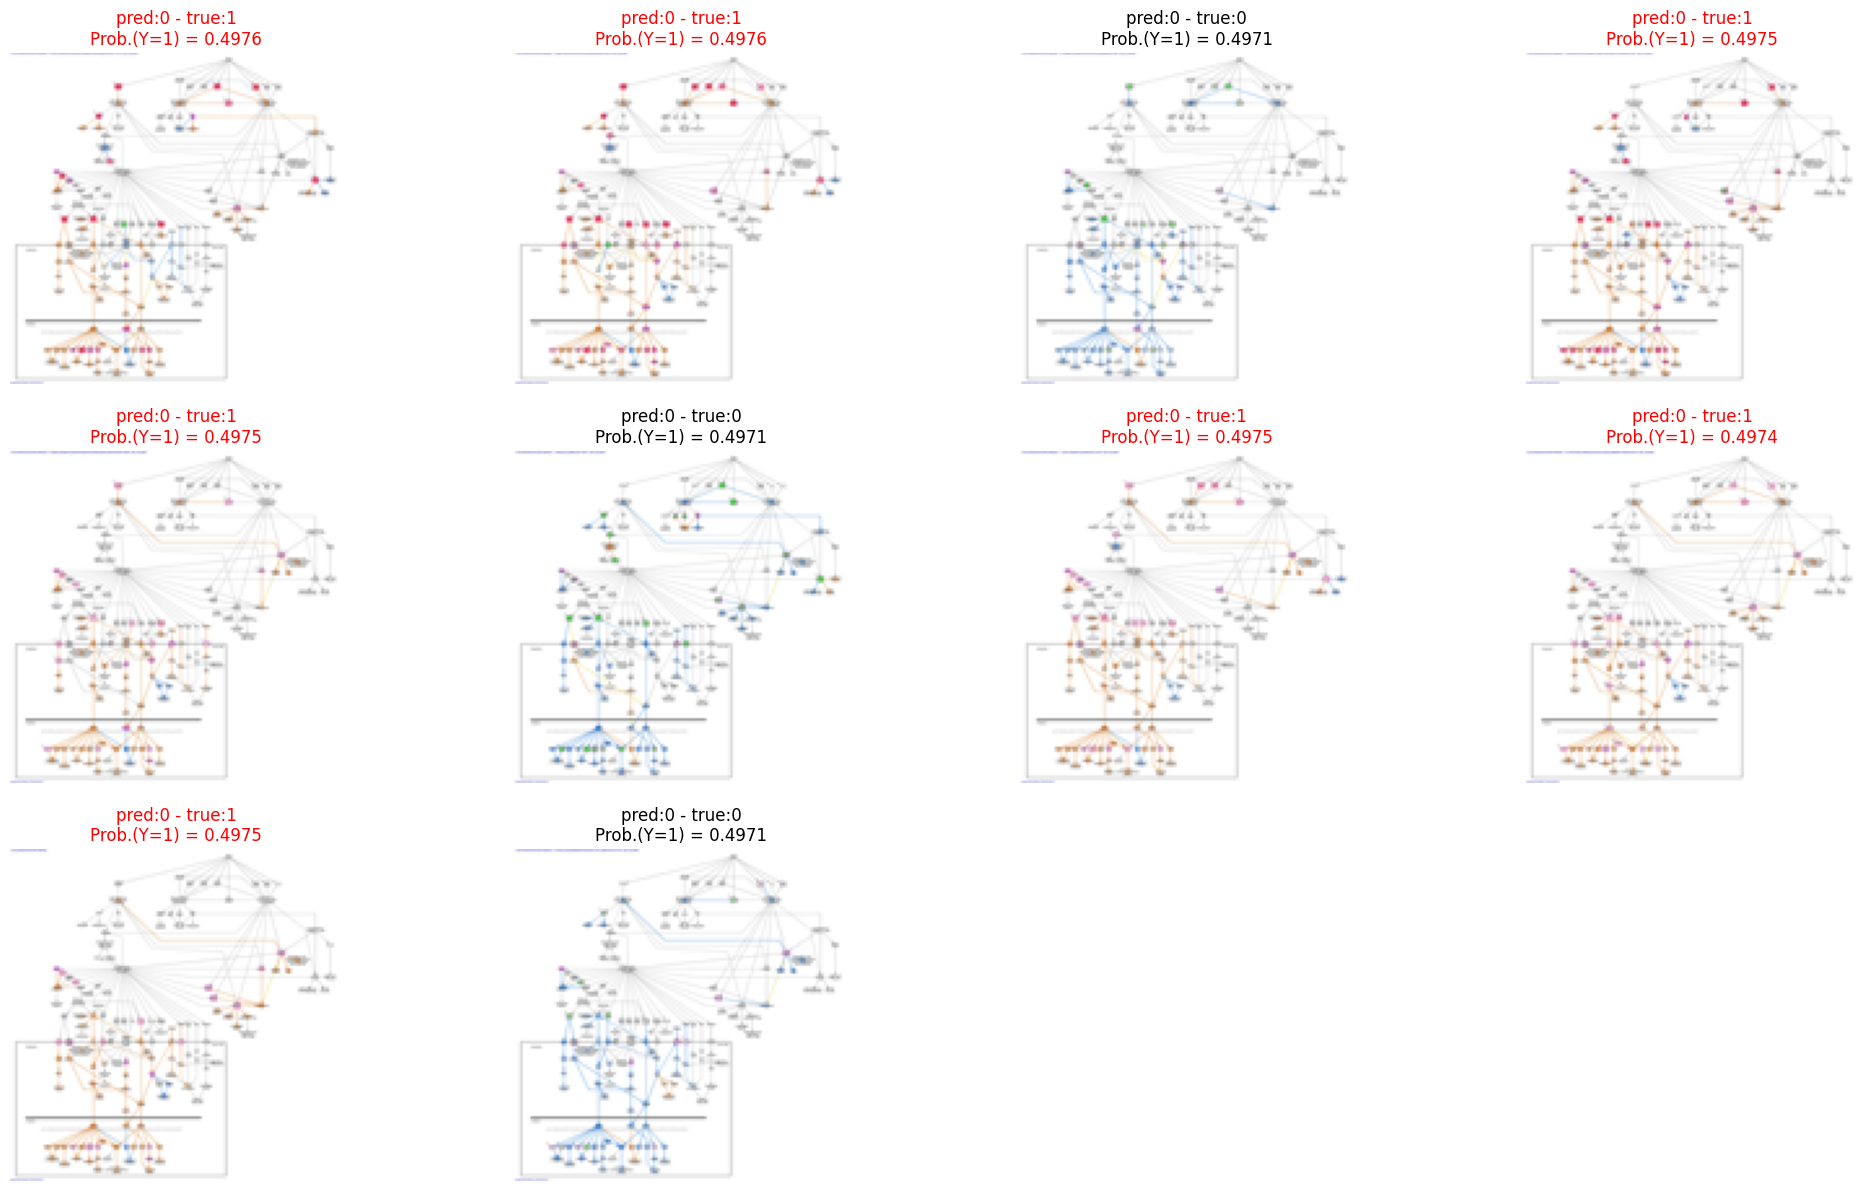

In [ ]:
# testデータの画像と予測ラベル・正答ラベル・予測確率を出力
plt.figure(figsize = (25, 25))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.axis("off")
    if pred[i] == true[i]:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]))
    else:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]), color = "red") # 分類が間違っていた場合，赤字で書き込む

    tmp = test_x[i][0].to('cpu').detach().numpy().copy()
    tmp = tmp.transpose(1, 2, 0)
    img_pil = Image.fromarray((tmp*255).astype(np.uint8))
    plt.imshow(img_pil)




In [ ]:
#2×2行列に正解不正解まとめる
cmat = confusion_matrix(true, pred)
print(cmat)

#感度特異度の算出
tn, fp, fn, tp = cmat.flatten()

acc = round((tp+tn)/(tp+tn+fp+fn),4)
sen = round(tp/(tp+fn),4)
spe = round(tn/(tn+fp),4)
ppv = round(tp/(tp+fp),4)
npv = round(tn/(tn+fn),4)
print("acc=",acc,"sen=",sen," ,spe=",spe," ,ppv=",ppv," ,npv=",npv)



[[3 0]
 [7 0]]
acc= 0.3 sen= 0.0  ,spe= 1.0  ,ppv= nan  ,npv= 0.3


<ipython-input-27-cc60bd63efc6>:11: RuntimeWarning: invalid value encountered in long_scalars
  ppv = round(tp/(tp+fp),4)


Cutoff-value: 0.4974 Sensitivity: 1.0 Specificity:  1.0


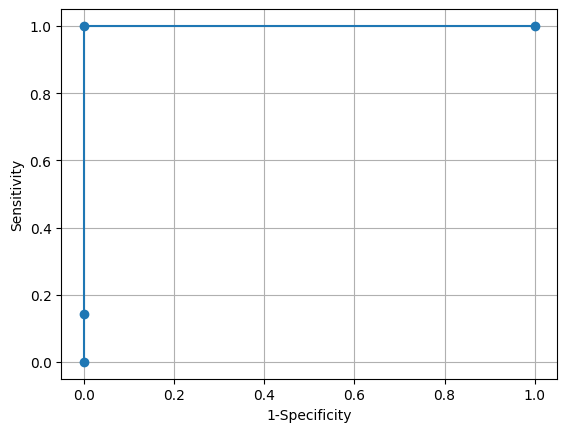

In [ ]:
#ROC curve

fpr, tpr, thresholds = roc_curve(true, prob)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
#plt.savefig(path+'/roc_curve.png')

Youden_index = tpr-fpr
index = np.where(Youden_index==max(Youden_index))[0][0]

cutoff = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]
print("Cutoff-value:",round(cutoff,4),"Sensitivity:",round(sensitivity,4),"Specificity: ",round(specificity,4))




In [ ]:
#!pip install grad-cam -q
#!conda install grad-cam

Grad-CAM

In [ ]:
# Grad-CAM

In [ ]:
#読み込み
model = torch.load('model.pt')
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
target_layer = model.conv4[1]

In [ ]:
gradcam = GradCAM(model, target_layer)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


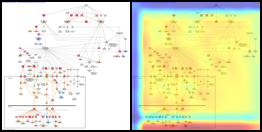

In [ ]:
image_number = 1
torch_img = torch.tensor(np.expand_dims(test_x[image_number][0], 0)).to(device) #画像をTorch
images = []
mask, _ = gradcam(torch_img)
heatmap, result = visualize_cam(mask, torch_img)
image0 = torch.squeeze(torch_img,dim=0)
images.extend([image0.cpu(), result])
grid_image = torchvision.utils.make_grid(images, nrow=2)
transforms.ToPILImage()(grid_image)

Finetuning

In [ ]:
model = models.vgg16(pretrained=True)# 事前トレーニングされたVGG16モデルを取得
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)   # 入力サイズはデフォルトの4096 出力はデフォルトの1000から2に変更
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPUで使用できるように指定
model = model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 転移学習で学習させるパラメータ
params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし

classifier.6.weight
classifier.6.bias


In [ ]:
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザー
optimizer = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)



#Trainig用
def train(train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc



#Validation用
def valid( test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            #break

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

'''誤差(loss)を記録する空の配列を用意'''
acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []


In [ ]:
nepoch = 50

#学習 1回目の学習は行わず評価のみ
for epoch in range(nepoch):

    if(epoch > 0):
        loss, acc = train(train_dataloader)
    else:
        loss, acc = valid(train_dataloader)

    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.7139 acc: 0.5143 val_loss: 0.7040 val_acc: 0.5500
epoch 1, loss: 0.6866 acc: 0.4286 val_loss: 0.6679 val_acc: 0.8000
epoch 2, loss: 0.6716 acc: 0.6143 val_loss: 0.6066 val_acc: 0.9000
epoch 3, loss: 0.5763 acc: 0.7286 val_loss: 0.5255 val_acc: 1.0000
epoch 4, loss: 0.5715 acc: 0.7714 val_loss: 0.4179 val_acc: 1.0000
epoch 5, loss: 0.4522 acc: 0.8857 val_loss: 0.3277 val_acc: 1.0000
epoch 6, loss: 0.3106 acc: 0.9286 val_loss: 0.2690 val_acc: 1.0000
epoch 7, loss: 0.2915 acc: 0.9000 val_loss: 0.2124 val_acc: 1.0000
epoch 8, loss: 0.1887 acc: 0.9857 val_loss: 0.1843 val_acc: 1.0000
epoch 9, loss: 0.2176 acc: 0.9143 val_loss: 0.1590 val_acc: 1.0000
epoch 10, loss: 0.2758 acc: 0.9429 val_loss: 0.1263 val_acc: 1.0000
epoch 11, loss: 0.1841 acc: 0.9857 val_loss: 0.1314 val_acc: 1.0000
epoch 12, loss: 0.1544 acc: 0.9000 val_loss: 0.1160 val_acc: 1.0000
epoch 13, loss: 0.1757 acc: 1.0000 val_loss: 0.0858 val_acc: 1.0000
epoch 14, loss: 0.1053 acc: 1.0000 val_loss: 0.0992 val_ac

In [ ]:
#modelの保存
torch.save(model, 'model_finetuning.pt')


正解率： 100.0 %


Text(0, 0.5, 'acc')

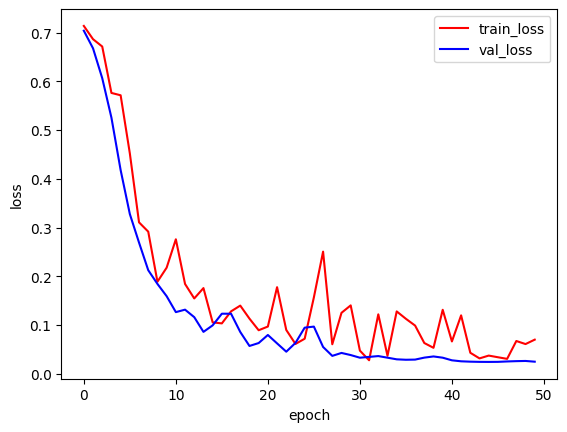

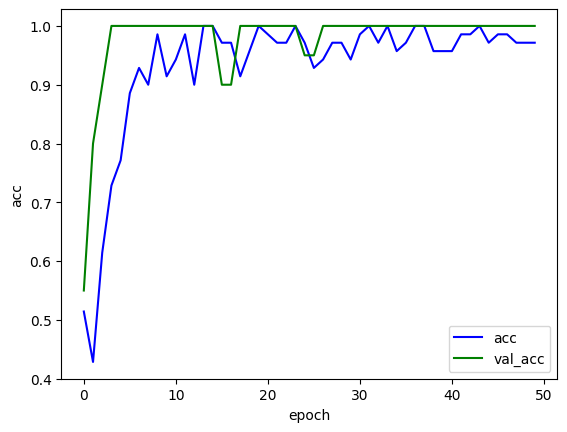

In [ ]:
print('正解率：',val_acc_list[-1]*100, '%')

'''結果の表示'''
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')